<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/06/Assignment_6_Companion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6 Companion Notebook: Motivation for Neural Networks

Learning Objectives:
* Understand the limitations of logistic regression through an example
* Become familiar with feedforward, multi-layer neural networks
* Fit a neural network to a dataset and examine the results

## Titanic: The Sequel

In order to motivate the need for neural networks, we're going to return to the Titanic dataset and examine a particular limitation of logistic regression.

We'll begin by loading the data.

In [1]:
import gdown
import pandas as pd

gdown.download('https://drive.google.com/uc?authuser=0&id=1XIFiL3WxxR6M2nWgADi3xWvuRO6A-Ov8&export=download', 'titanic_train.csv', False)
df = pd.read_csv('titanic_train.csv')
df

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1XIFiL3WxxR6M2nWgADi3xWvuRO6A-Ov8&export=download
To: /content/titanic_train.csv
100%|██████████| 61.2k/61.2k [00:00<00:00, 25.8MB/s]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


From some of the exploratory analysis in the [assignment 5 walkthrough](https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/05/assignment05.ipynb#scrollTo=56C4fPtK7YeQ), we know that both age and sex are good predictors of whether or not someone survived the Titanic sinking.  That said, we saw that the effect surivival rate for women wasn't dramatically changed by age, but the survival rate for men was dramatically changed.  Here are some plots showing this result.

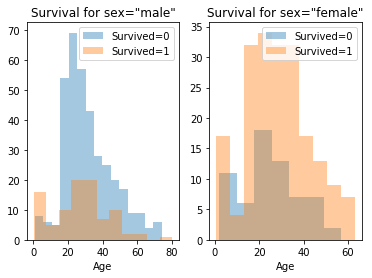

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
legend_entries = []
plt.subplot(1,2,1)
for groups in df[df['Sex'] == 'male'].groupby('Survived'):
    sns.distplot(groups[1]['Age'].dropna(), kde=False)
    legend_entries.append('Survived=%d'% groups[0])
plt.legend(legend_entries)
plt.title('Survival for sex="male"')

plt.subplot(1,2,2)
legend_entries = []
for groups in df[df['Sex'] == 'female'].groupby('Survived'):
    sns.distplot(groups[1]['Age'].dropna(), kde=False)
    legend_entries.append('Survived=%d'% groups[0])
plt.legend(legend_entries)
plt.title('Survival for sex="female"')
plt.show()

# while we're at it, silence annoying sklearn warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

It would be great if we could use logistic regression in order to leverage this information.  A good first pass would be to take both of these features (where we will encode `sex` using an `is_male` feature) and pass them into a logistic regression.  The plot below shows the results of this analysis where we represent the training data along with the lines of equal probability for the resultant model.  We'll divide this into two cells, one where we prepare the data and the other where we fit the model and show the plot

In [3]:
# get rid of null values for age since this is just an illustrative example.
# this would not be a good thing to do if we were trying to evalutate the 
# performance of a model.
df_filtered = df[['Age', 'Sex', 'Survived']].dropna()
experiment_1_data = pd.concat((pd.get_dummies(df_filtered['Sex'], drop_first=True), df_filtered['Age']), axis=1)
experiment_1_outputs = df_filtered['Survived']
experiment_1_data

,male,Age
0,1,22.0
1,0,38.0
2,0,26.0
3,0,35.0
4,1,35.0
6,1,54.0
7,1,2.0
8,0,27.0
9,0,14.0
10,0,4.0


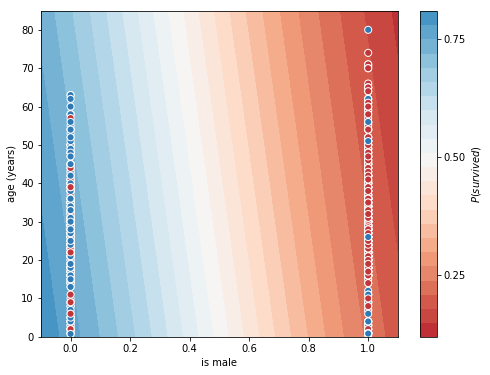

In [4]:
from sklearn.linear_model import LogisticRegression
import numpy as np

model = LogisticRegression()
model.fit(experiment_1_data, experiment_1_outputs)

xx, yy = np.mgrid[-.1:1.1:.01, 0:85:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(survived)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_1_outputs, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlim=(-.1, 1.1),
       ylim=(0, 85),
       xlabel="is male", ylabel="age (years)")
plt.show()

### *Notebook Exercise 1 (10 minutes)*

(a) In English, explain what this graph is showing (defer interpretation for now, we just want to make sure you have an idea of what is represented in the plot, e.g., x-axis, y-axis, colored areas).

(b) Given the decision boundary, how does the model predict who will survive versus not survive?  What does it predict for male babies?

#### *Expand for Solution*

***Solution***

(a) the graph shows a contour plot of the probability returned by the logistic regression model.  Also shown on the graph are the training points (blue are passengers that survived and red are ones that did not).

(b) Even though the model is not quite as simple as one that just uses the is male feature, it never the less has a decisino boundary that will always predict that a male will not survive and a female will survive.

### Adding the `is_young_male` feature

Based on this plot it seems that what we need is to have a model that is able to simulataneously predict that all women survived and that all very young boys survived.  One way we can achieve this is by engineering a special `is_young_male` feature that is 1 if the person is under the age of 5 and male.  The feature will take a value of 0 otherwise.

In [0]:
is_young_male = (experiment_1_data['male']) & (experiment_1_data['Age'] < 5).astype(int)
is_young_male.name = 'is_young_male'
experiment_2_data = pd.concat((experiment_1_data, is_young_male), axis=1)
experiment_2_data
# these don't change, but just to be consistent with variable naming
experiment_2_outputs = experiment_1_outputs

Next, we can take fit the model to this new dataset and create a plot that shows the results of fitting the model.  To make the plot a bit easier to interpret, we'll just plot the model's binary output (0 or 1) rather than the probability.  This will make it really clear what the model is doing with the points in the lower righthand corner.

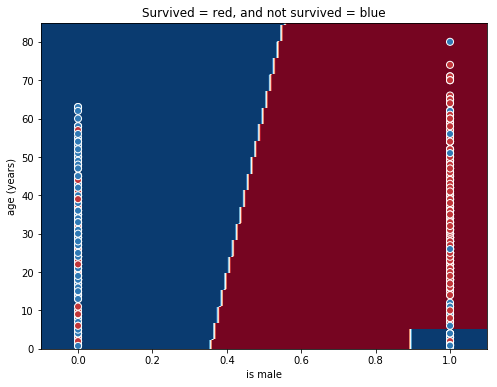

In [8]:
model = LogisticRegression()
model.fit(experiment_2_data, experiment_1_outputs)

xx, yy = np.mgrid[-.1:1.1:.01, 0:85:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
# Note: we are setting the is_young_male feature for a male value above 0.9 to
# aid in visualization.  Of course, the feature can only take on value 0 or 1
is_young_male_grid = np.logical_and(grid[:,0] >= 0.9, grid[:,1] < 5).astype(np.int)[:,np.newaxis]

grid = np.hstack((grid, is_young_male_grid))
outputs = model.predict(grid).reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, outputs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax.set_title('Survived = red, and not survived = blue')

ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_2_outputs, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlim=(-.1, 1.1),
       ylim=(0, 85),
       xlabel="is male", ylabel="age (years)")
plt.show()

### *Notebook Exercise 2 (10 minutes)*

(a) Based on this graph, given a passenger's sex and age, what would the model predict?

(b) This seems to have achieved our goal of predicting that young males survived.  What are the limitations of this approach of hand coding these sorts of features?

#### *Expand for Solution*

***Solution***

(a) The model predicts that all women and all males under the age of 5 will survive.  Everyone else will not.

(b) Handcoding is very labor intensive and results in a lot of trial and error.  There may be other useful trends in the sex / age data that we don't hand code since we don't have the right intuition.

## Enter the Neural Network!

Next, we're going to learn about a particular type of neural network called a multilayer perceptron (you'll know exactly what one is by the end of this assignment!).  For now, we won't give you a very sophisticated mental model of what this neural network is doing.  Just think of it as automating the process of discovering useful representations for learning.  We are trying to avoid needing to hand engineer features, such as we did with the `is young male` feature.

In [9]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', random_state=50)
model.fit(experiment_1_data, experiment_1_outputs)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=2, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=50, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

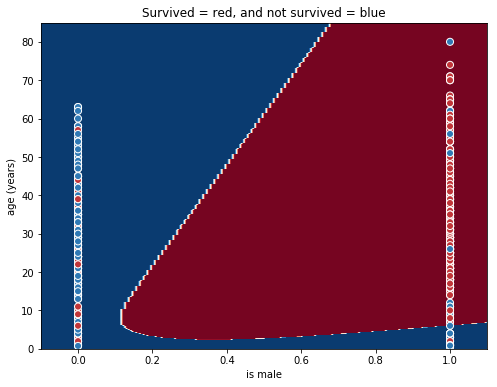

In [10]:
xx, yy = np.mgrid[-.1:1.1:.01, 0:85:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
outputs = model.predict(grid).reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, outputs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax.set_title('Survived = red, and not survived = blue')

ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_2_outputs, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlim=(-.1, 1.1),
       ylim=(0, 85),
       xlabel="is male", ylabel="age (years)")
plt.show()

### *Notebook Exercise 3 (5 minutes)*

Based on this graph how does the network decide whether a passenger will survive or not survive.

#### *Expand for Solution*

***Solution***

All women and all males under the age of 6ish are predicted to survive.  All others are predicted not to survive.

### Examining the Intermediate Representations in the Network

While we have yet to really unpack *how* the neural network was able to achieve this feat, we can start to interrogate the learned model to undrestand a bit of what it is doing.

For the purposes of this next set of plots and exercise, you should have the following mental model of what the network is doing (all of this will be made 100% precise when you go through the rest of the assignmnet document, but for now things will be explained on a conceptual level).

* Neural networks learn internal representations of the input data that help them make predictions (you may recall that this was Big Idea #4 in assignment 1).
* In this case we instructed the neural network to learn exactly $2$ internal representations of the input data.
* The network will use these two internal representations, not the original input data, in order to arrive at its final decision.

In the plot below, we show the values for each of the $2$ learned internal representations in the network.  You can think of these representations as providing a remapping of the data into a new space that is then used to make the prediction as to whether the person was likely to surive or not survive.

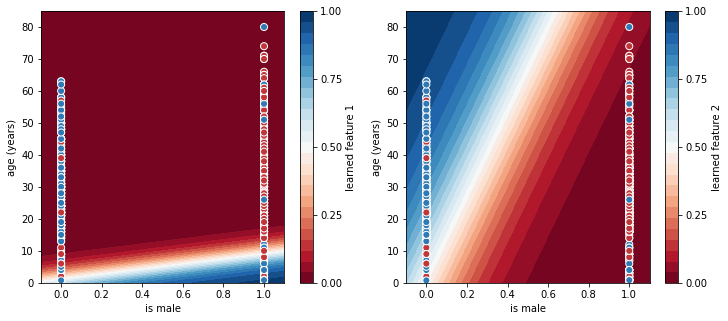

In [0]:
hidden_units = 1/(1+np.exp(-np.matmul(np.array(experiment_1_data), model.coefs_[0]) + model.intercepts_[0]))

f = plt.figure(figsize=(12, 5))
hidden_units = 1/(1+np.exp(-np.matmul(grid, model.coefs_[0]) + model.intercepts_[0]))

for i in range(2):
    ax = f.add_subplot(1,2,i+1)
    contour = ax.contourf(xx, yy, hidden_units[:,i].reshape(xx.shape), 25, cmap="RdBu",
                        vmin=0, vmax=1)

    ax.scatter(experiment_1_data['male'], experiment_1_data['Age'], c=experiment_2_outputs, s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("learned feature %d" %(i+1))
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.set(xlim=(-.1, 1.1),
        ylim=(0, 85),
        xlabel="is male", ylabel="age (years)")
plt.show()

### *Notebook Exercise 4 (10 minutes)*

(a) What does first learned feature (left plot) appear to encode?

(b) What does the second learned feature (right plot) appear to encode?

#### *Expand for Solution*

***Solution***

(a) The first feature appears to encode the notion of being a very young male (although female babies are also included).

(b) The second feature seems to encode whether or not the passenger is a female.  The slant of the lines makes this more of an `is non infant female` feature.

### Key takeaways

While this was a relatively simple example of how a neural network could be applied, the capabilities that you just saw in this notebook have immense significance.  The ability of a neural network to take input data that may not be suited for prediction (e.g., sex and age) and transform it into a representation that is more useful for prediction is perhaps the most significant aspect of neural networks.  Here is a summmary of what happened in this notebook.

* We reexamined the Titanic dataset and showed that adding the `age` feature doesn't really help in making predictions versus just using `sex`.
* We showed that we can manually add a feature called `is_young_male` that can help us in prediction.
* We showed that neural networks can automate this process of feature learning by developing their own internal representations.
* We showed that the neural network, in this case, learned an internal representation that is very similar to the `is_young_male` and `sex` representation.

In the rest of the assignment we'll be unpacking what exactly a neural network is.  You'll learn how it functions and how you would fit the parameters of one.